# Week 7 - HMM Implementation

In [10]:
%matplotlib inline
import numpy as np
from scipy.stats import skew
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#### (1) Load the data from HMMobs.csv and plot the observations.

You'll need to figure out an time axis vector for the data (it was recorded starting from midnight at even intervals over 24 hours).

1974


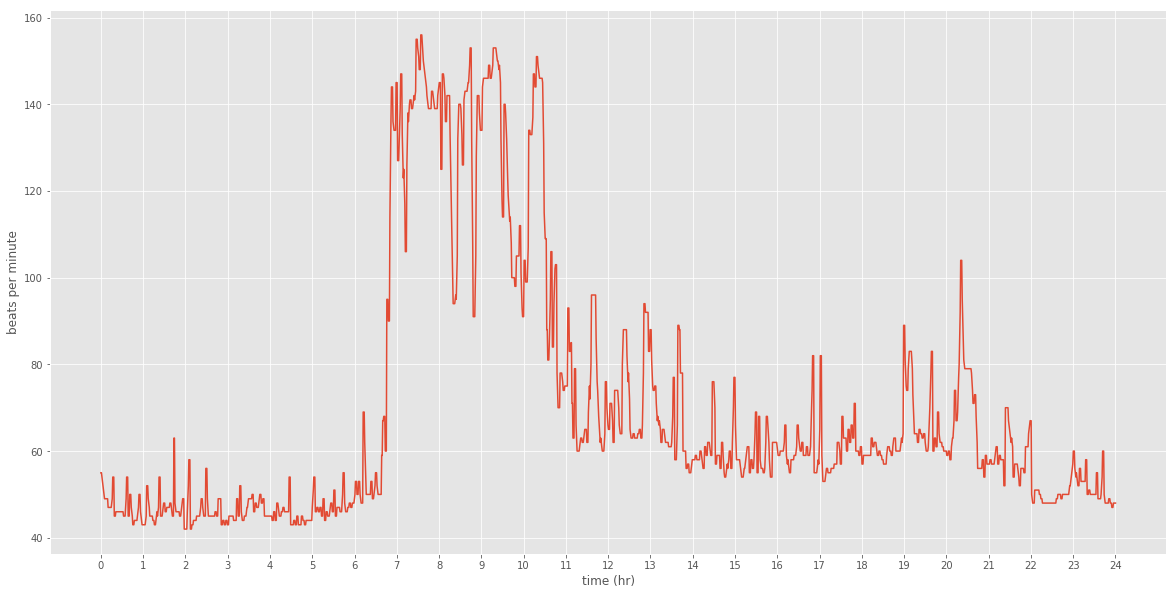

In [11]:
# Load the data from the .csv file
hr = np.loadtxt("./wk7_HR.csv")

# Determine proper x axis for time frame data was acquired
print(hr.size)
t = np.linspace(0, 24, num = hr.size)

# Plot heart rate for the 24hr period
plt.figure(figsize = (20, 10))
plt.plot(t, hr)
plt.xlabel("time (hr)")
plt.ylabel("beats per minute")
plt.xticks(np.arange(0, 25, 1))
plt.show()

#### (2) Do you see regions where there might be differences in behavior?

Yes. There appears to be 3 main regions the heart rate of the individual falls under. From 10PM until 6AM the individual remains below 60 bpm; this could be indicative of when the indivdual is asleep. At 6AM, the heart rate of the individual rises above 120 bpm, which is likely a time when the individual is exercising or participating in an extraneous activity. Around 11AM, the heart rate drops to around 60 bpm and remains there until the individual goes to sleep, which is indicated by the drop in heart rate.

#### (3) Based on when you might expect someone would be asleep, plot the histogram of resting heart rate values.

Given the shape of this distribution, do you think any transformation of the data would be helpful?

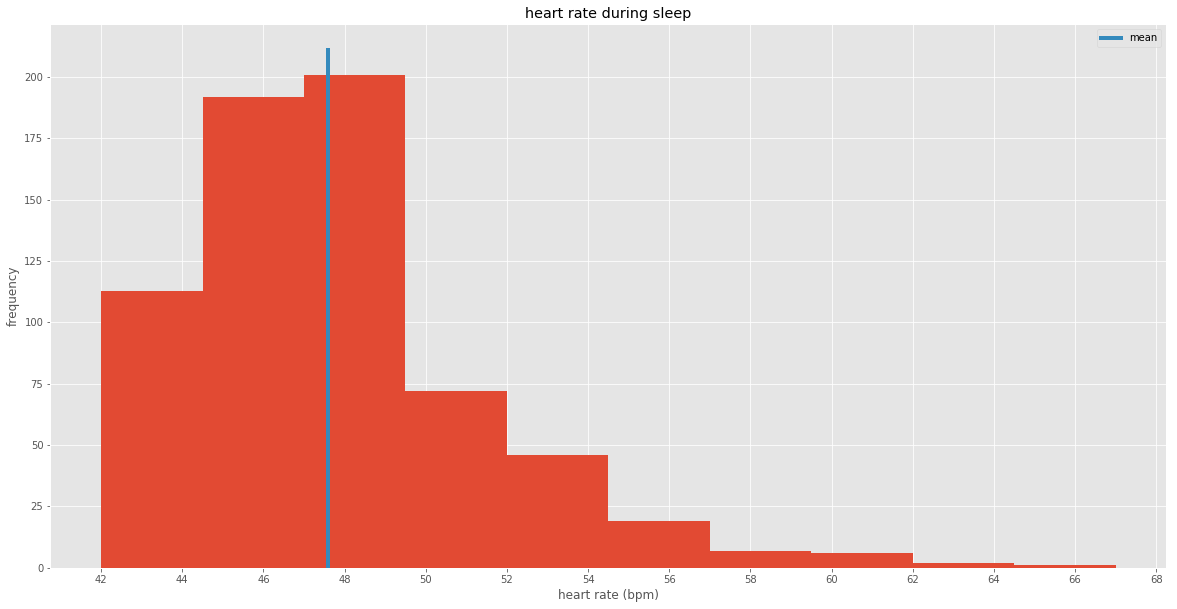

Skew of untransformed heart rate data: 1.331143759324204


In [12]:
# Answer
# Based on the plot from (1), I would guess that the individual would be asleep during 10PM - 6AM.

# Create list for heart rates during sleep will be stored
hrAsleep = []

# Iterate through all times and store heart rate in list if it is during 10PM - 6AM
for i in range(len(hr)):
    if(t[i] > 22 or t[i] < 6):
        hrAsleep.append(hr[i])

# Change the list to an array
hrAsleep = np.asarray(hrAsleep)

# Plot histogram of heart rates with line at mean
plt.figure(figsize = (20, 10))
plt.title("heart rate during sleep")
plt.ylabel("frequency")
plt.xlabel("heart rate (bpm)")
plt.xticks(np.arange(40, 70, 2))
hist = plt.hist(hrAsleep, bins = 10)
plt.plot([np.mean(hrAsleep), np.mean(hrAsleep)], [0, hist[0].max() + 10], label = "mean", linewidth = 4)
plt.legend()
plt.show()

print("Skew of untransformed heart rate data:", skew(hrAsleep))

The shape of the distribution resembles a Gaussian distribution, but it is skewed right. In order to adjust for the right skewness we could take the log of the distribution to make the skew less positive.

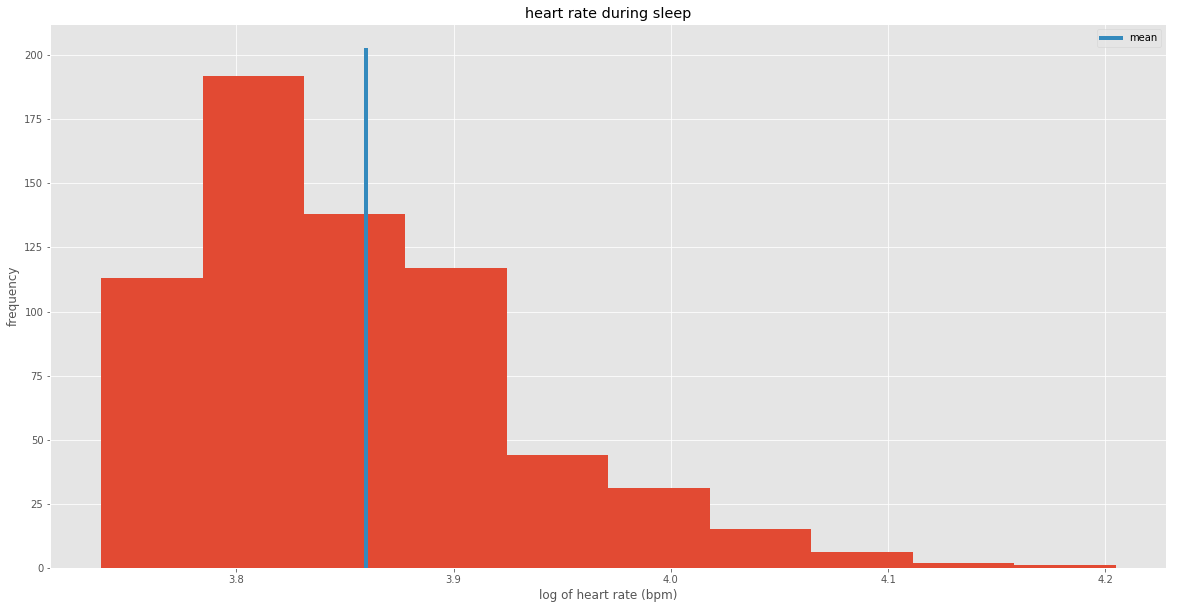

Skew of transformed heart rate data: 1.052157569010751


In [13]:
# Take the log of the heart rates 
hrAsleepTransform = np.log(hrAsleep)

# Plot the transformed data
plt.figure(figsize = (20, 10))
plt.title("heart rate during sleep")
plt.ylabel("frequency")
plt.xlabel("log of heart rate (bpm)")
hist = plt.hist(hrAsleepTransform, bins = 10)
plt.plot([np.mean(hrAsleepTransform), np.mean(hrAsleepTransform)], [0, hist[0].max() + 10], label = "mean", linewidth = 4)
plt.legend()
plt.show()

print("Skew of transformed heart rate data:", skew(hrAsleepTransform))

Transforming the data using the log function did reduce the skew of the data closer to zero. Therefore, a transformation of the data was useful.

#### (4) One way to deal with noisy data is to use a moving average. Plot the moving average of the data for two different windows. How does this help visualize the data? What is lost using this approach?

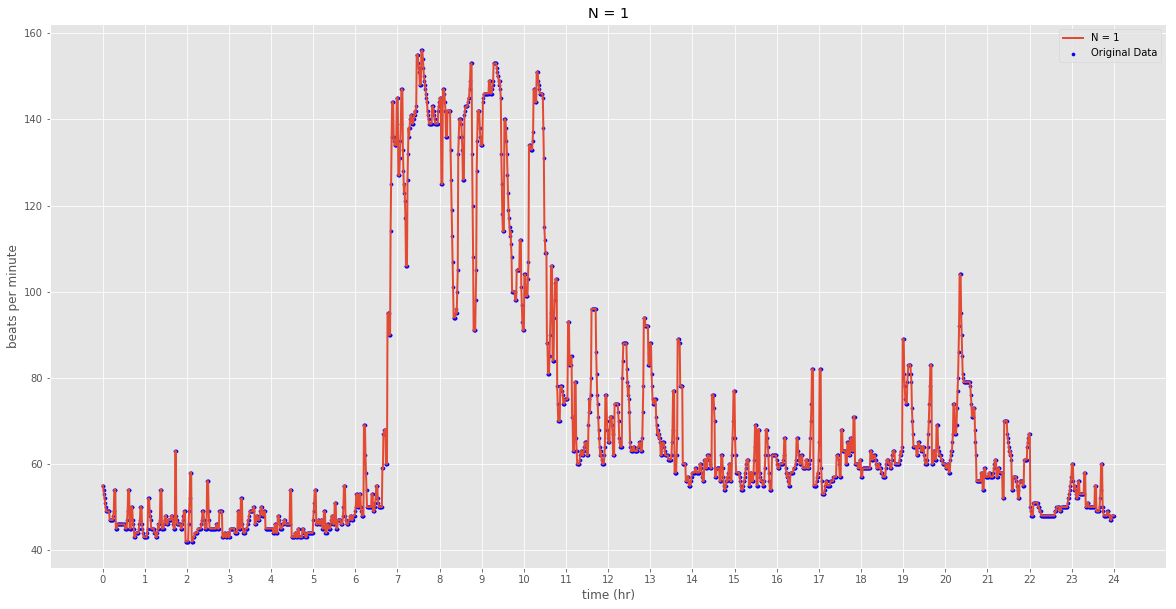

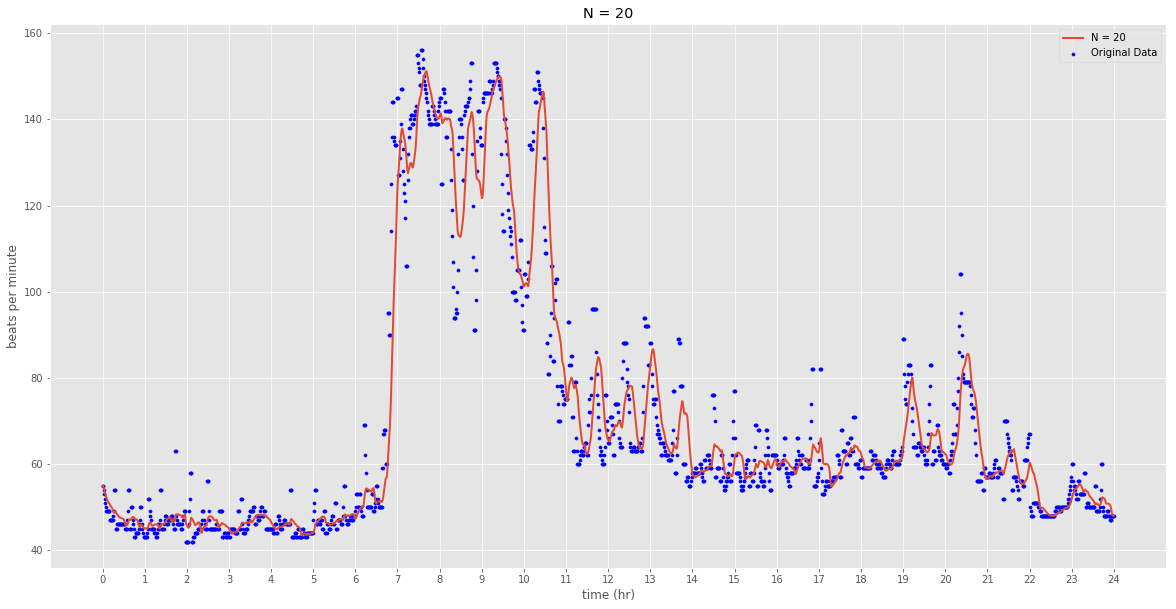

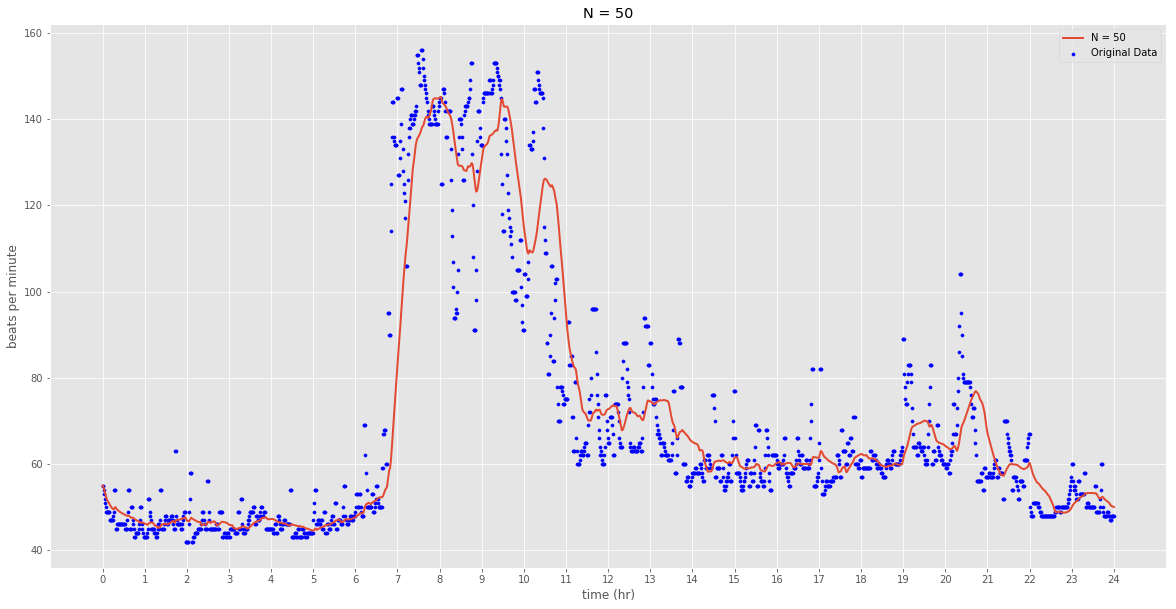

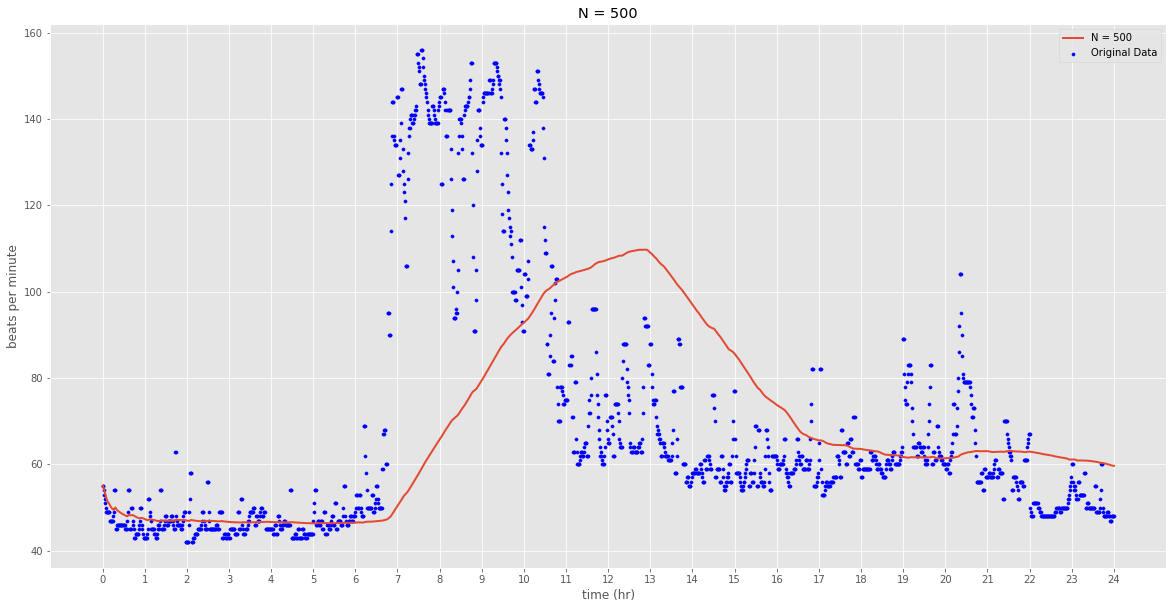

In [14]:
# Answer
# Defines function for calculating the moving average of the last N points of an array
def movingAverage(data, lastN):
    newData = np.zeros_like(data)
    
    for i in range(len(data)):
        if(i < lastN):
            avg = np.mean(data[0:i+1])
        else:
            avg = np.mean(data[i-(lastN-1):i+1])   
        newData[i] = avg
    
    return newData

assert(np.all(hr == movingAverage(hr, 1)))

# Plot moving average for N = 1 over original data
plt.figure(1, figsize = (20, 10))
plt.plot(t, movingAverage(hr, 1), label = 'N = 1', linewidth = 2)
plt.scatter(t, hr, label = 'Original Data', c = 'b', s = 10)
plt.title('N = 1')
plt.xlabel("time (hr)")
plt.ylabel("beats per minute")
plt.legend()
plt.xticks(np.arange(0, 25, 1))

# Plot moving average for N = 20 over original data
plt.figure(2, figsize = (20, 10))
plt.plot(t, movingAverage(hr, 20), label = 'N = 20', linewidth = 2)
plt.scatter(t, hr, label = 'Original Data', c = 'b', s = 10)
plt.title('N = 20')
plt.xlabel("time (hr)")
plt.ylabel("beats per minute")
plt.legend()
plt.xticks(np.arange(0, 25, 1))

# Plot moving average for N = 50 over original data
plt.figure(3, figsize = (20, 10))
plt.plot(t, movingAverage(hr, 50), label = 'N = 50', linewidth = 2)
plt.scatter(t, hr, label = 'Original Data', c = 'b', s = 10)
plt.title('N = 50')
plt.xlabel("time (hr)")
plt.ylabel("beats per minute")
plt.legend()
plt.xticks(np.arange(0, 25, 1))

# Plot moving average for N = 500 over original data
plt.figure(4, figsize = (20, 10))
plt.plot(t, movingAverage(hr, 500), label = 'N = 500', linewidth = 2)
plt.scatter(t, hr, label = 'Original Data', c = 'b', s = 10)
plt.title('N = 500')
plt.xlabel("time (hr)")
plt.ylabel("beats per minute")
plt.legend()
plt.xticks(np.arange(0, 25, 1))
plt.show()

When a moving average is taken of the data the curve begins to smooth and the noise is removed. Note that when the size of N, or the window, is equal to the interval the data was aquired, the data remains the same. However, when the size of N becomes larger, data is lost, and when the size of N becomes unnecessarily large, the data begins to lose too much data and the information has little value. The moving average can also be thought of as a low pass filter, where the high frequency changes are "filtered" out. N is equivalent to the cutoff frequency, where the larger the N the lower the cutoff frequency.

#### (5) We're going to fit an HMM model to this data with three underlying states. This involves three sets of parameters about the model—describe each briefly.

The three sets of parameters necessary to fit an HMM model are the initial, transmission, and emission probabilities. The initial probabilities are the probabilities of being in a certain state at the beginning of the oberservations. The transmission probabilities are the probabilities of moving from a specific state to another state. And finally, the emission probabilities are the probabilities of observing a certain output being in a specific state.

#### (6) Fit an HMM model with Gaussian emissions to the data. Use any transformations as necessary.

How does the model respond to rapid state changes? Overlay the raw measurements and HMM state over time.

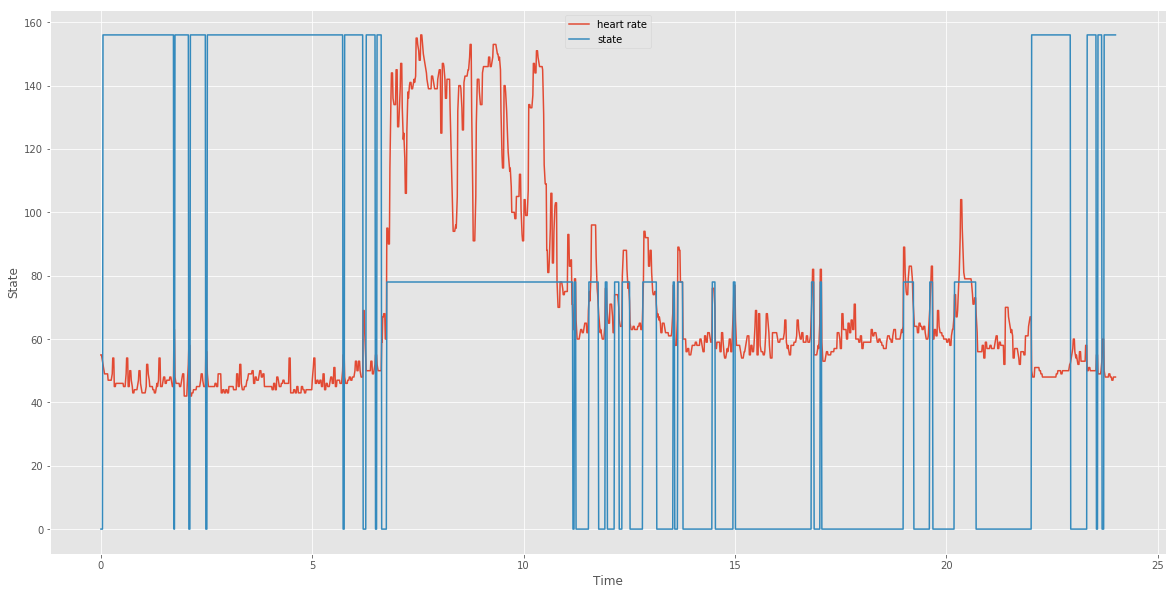

In [15]:
# Answer
# Rename GaussianHMM function as hmm
hmm = GaussianHMM

# Create hmm model with 3 states and fit the model to the heart rate data
hmmModel = hmm(n_components = 3, n_iter = 10000, tol = 1e-6)
hrReshape = np.reshape(hr, newshape=(len(hr), 1))
hmmModel.fit(hrReshape)

# Predict the hidden states of the model
hiddenStates = hmmModel.predict(hrReshape)

# Plot the states overlaye with the heart rate data
plt.figure(figsize = (20, 10))
hrPlot = plt.plot(t, hr, label = "heart rate")
plt.plot(t, hiddenStates * np.max(hr) / 2, label = "state")
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.show()

It appears that when there are rapid state changes, the model is responsive to it. We have established that the individual is asleep from 10PM to 6AM, but there are multiple spikes during this time interval that indicate the individual was changing states between sleep and awake, despite being awake for a shot period of time.

#### (7) From the HMM model determine, with a confidence interval, when the patient woke up in the morning. Compare this prediction to the data you obtain with the moving average.

Hint: `model.predict_proba(X)` can give you the probability of being in each state at each time point.

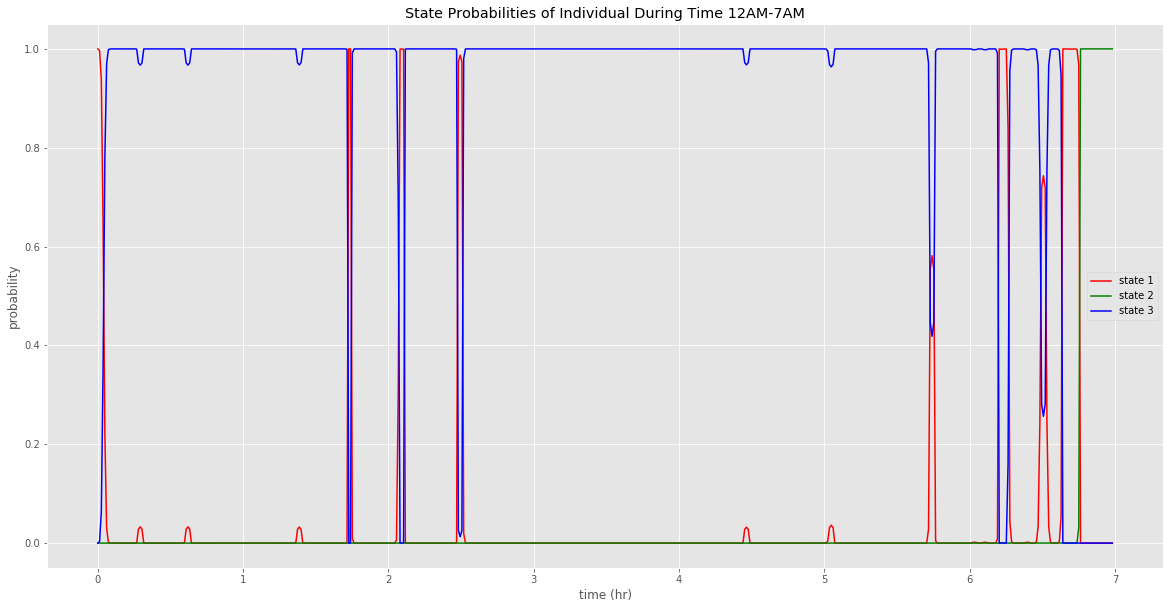

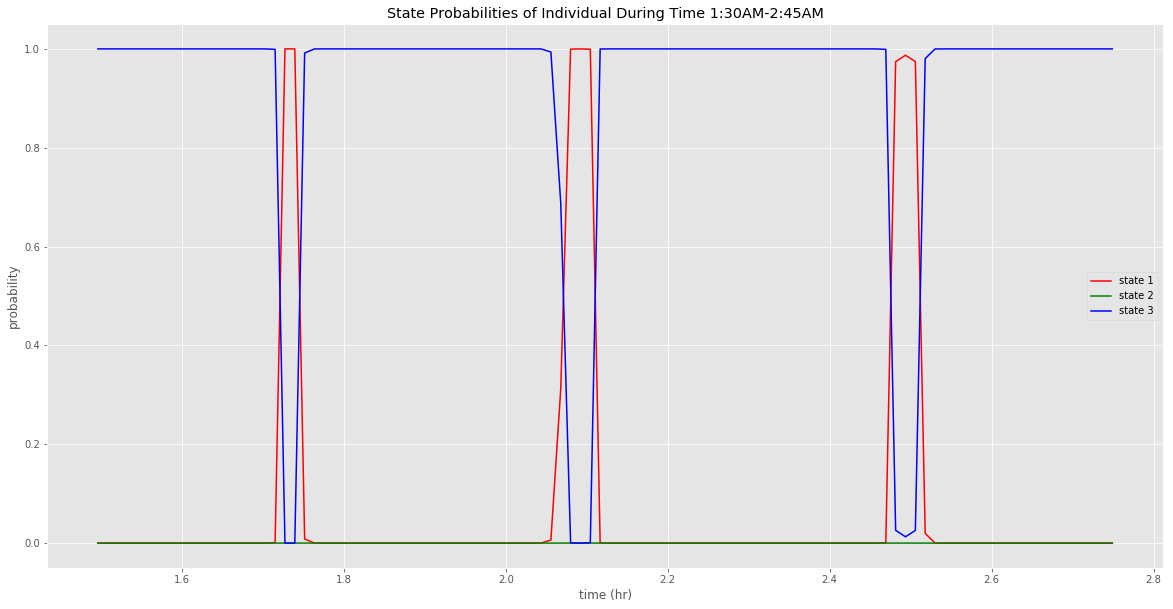

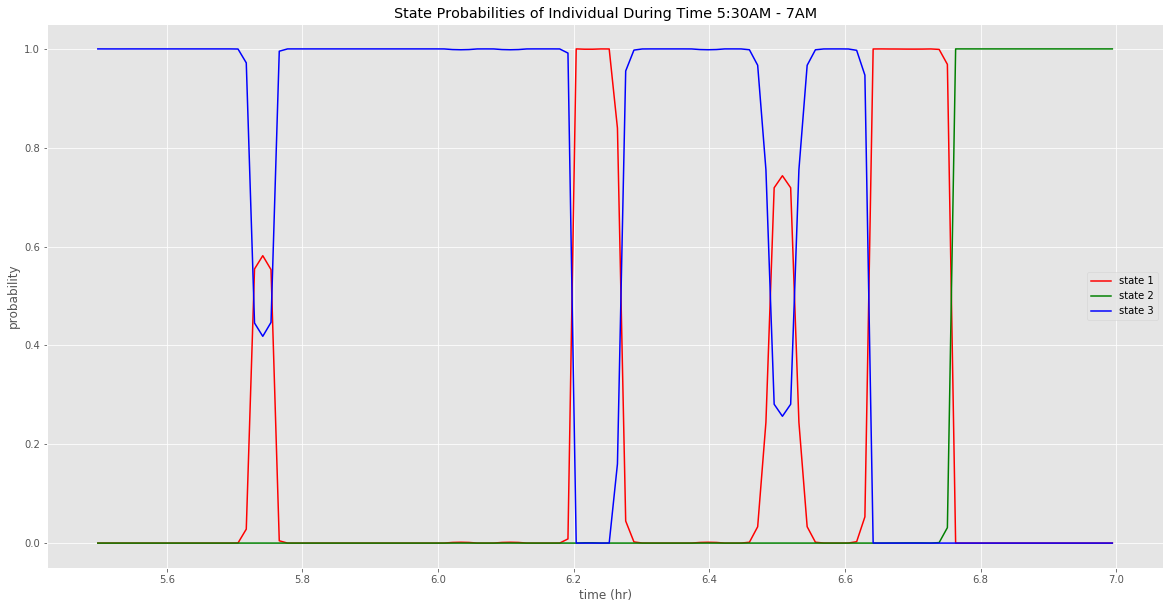

In [16]:
# Answer
# Store the probabilities of being in each state
stateProbs = hmmModel.predict_proba(hrReshape)
s1Prob = stateProbs[:, 0]
s2Prob = stateProbs[:, 1]
s3Prob = stateProbs[:, 2]

# Determine the indexs when the individual was asleep
startSleepIndex = 0
endSleepIndex = 0

for i in range(len(t)-1):
    if(t[i+1] > 22 and t[i] < 22):
        startSleepIndex = i
    if(t[i+1] > 7 and t[i] < 7):
        endSleepIndex = i

# Store heart rates of individual when asleep
hrSleepMorning = hr[0:endSleepIndex]
tSleepMorning = t[0:endSleepIndex]
s1ProbSleep = s1Prob[0:endSleepIndex]
s2ProbSleep = s2Prob[0:endSleepIndex]
s3ProbSleep = s3Prob[0:endSleepIndex]

plt.figure(1, figsize = (20, 10))
plt.title("State Probabilities of Individual During Time 12AM-7AM")
plt.plot(tSleepMorning, s1ProbSleep, c = 'r',label = "state 1")
plt.plot(tSleepMorning, s2ProbSleep, c = 'g',label = "state 2")
plt.plot(tSleepMorning, s3ProbSleep, c = 'b',label = "state 3")
plt.xlabel("time (hr)")
plt.ylabel("probability")
plt.legend()

# Focus on regions 1:30AM - 2:45AM and 5:30AM - 7AM
# Determine the indices 1:30AM - 2:45AM
startIndex = 0
endIndex = 0

for i in range(len(t)-1):
    if(t[i+1] > 1.5 and t[i] < 1.5):
        startIndex = i
    if(t[i+1] > 2.75 and t[i] < 2.75):
        endIndex = i

plt.figure(2, figsize = (20, 10))
plt.title("State Probabilities of Individual During Time 1:30AM-2:45AM")
plt.plot(t[startIndex:endIndex+1], s1Prob[startIndex:endIndex+1], c = 'r',label = "state 1")
plt.plot(t[startIndex:endIndex+1], s2Prob[startIndex:endIndex+1], c = 'g',label = "state 2")
plt.plot(t[startIndex:endIndex+1], s3Prob[startIndex:endIndex+1], c = 'b',label = "state 3")        
plt.xlabel("time (hr)")
plt.ylabel("probability") 
plt.legend()

# Determine the indices 5:30AM - 7AM
startIndex = 0
endIndex = 0

for i in range(len(t)-1):
    if(t[i+1] > 5.5 and t[i] < 5.5):
        startIndex = i
    if(t[i+1] > 7 and t[i] < 7):
        endIndex = i

plt.figure(3, figsize = (20, 10))
plt.title("State Probabilities of Individual During Time 5:30AM - 7AM")
plt.plot(t[startIndex:endIndex+1], s1Prob[startIndex:endIndex+1], c = 'r',label = "state 1")
plt.plot(t[startIndex:endIndex+1], s2Prob[startIndex:endIndex+1], c = 'g',label = "state 2")
plt.plot(t[startIndex:endIndex+1], s3Prob[startIndex:endIndex+1], c = 'b',label = "state 3")        
plt.xlabel("time (hr)")
plt.ylabel("probability") 
plt.legend()

plt.show()

When looking at the state probability data from 12AM to 7AM there are two regions that show changes between awake and asleep. I focused in on these regions to better view the probabilities. It appears that at two of the spikes during 1:30 to 2:45 they change from a probability of 0 to 1 for a specific state. The other spike does not completely change. Therefore I can only be confident that the individual was awake at 1:45AM and 2:06AM.
From 5:30AM to 7AM there are two spikes that do not completely change therefore I can only state with confidence that the individual was awake from 6:10-6:15AM and 6:35-6:45AM. 

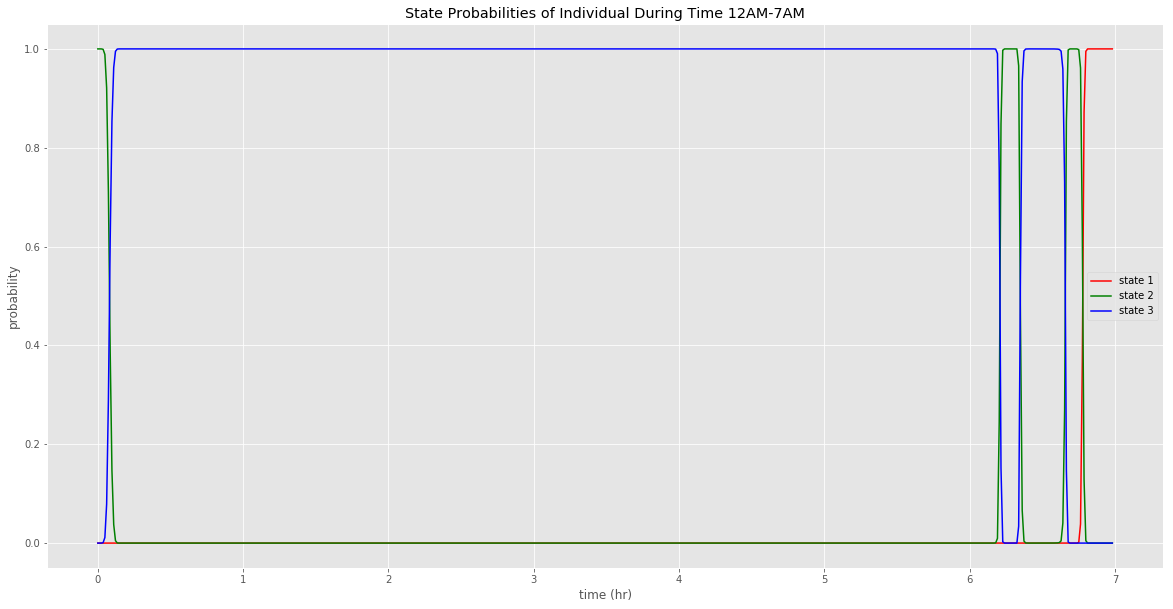

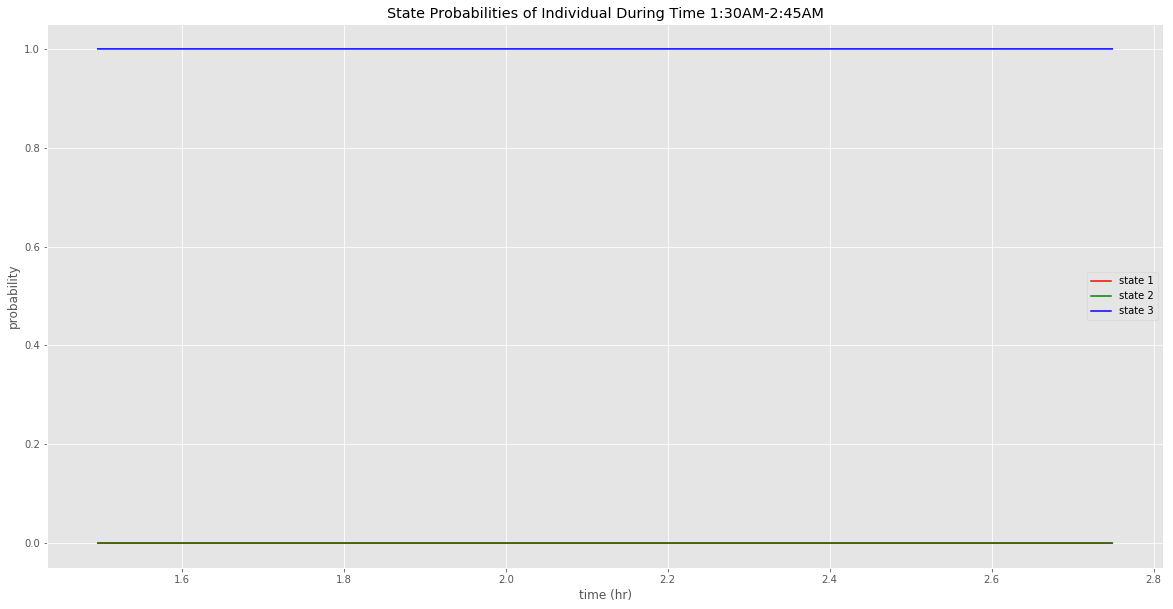

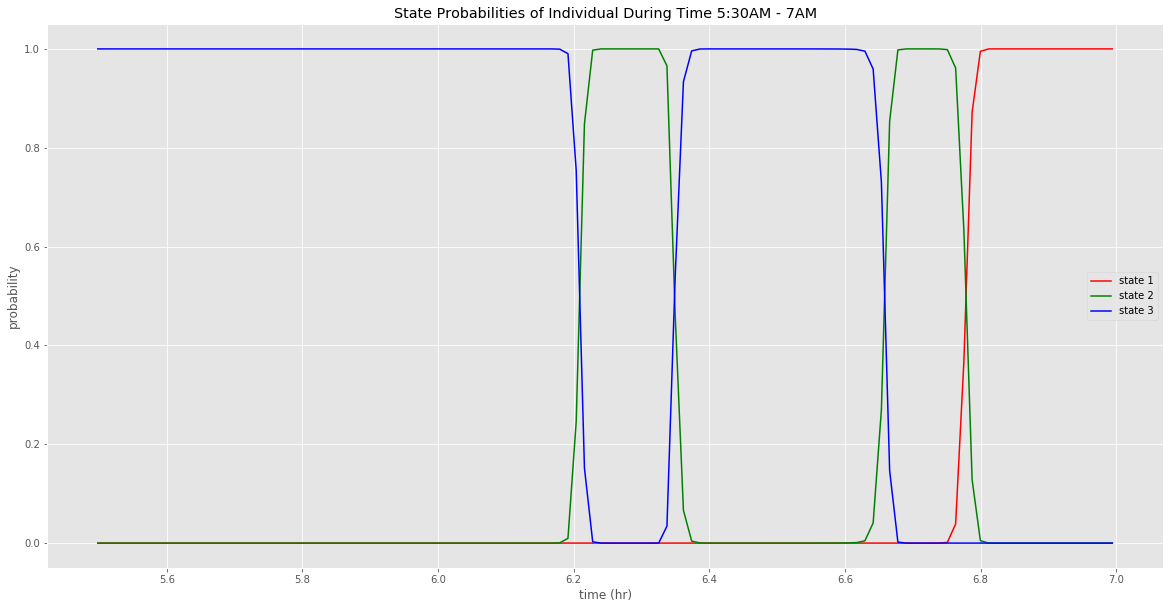

In [17]:
# Do again with moving average
N = 10
hrMovingAvgReshape = np.reshape(movingAverage(hr, N), newshape=(len(hr), 1))
hmmModel.fit(hrMovingAvgReshape)

# Predict the hidden states of the model
hiddenStates = hmmModel.predict(hrMovingAvgReshape)

# Store the probabilities of being in each state
stateProbs = hmmModel.predict_proba(hrMovingAvgReshape)
s1Prob = stateProbs[:, 0]
s2Prob = stateProbs[:, 1]
s3Prob = stateProbs[:, 2]

# Determine the indexs when the individual was asleep
startSleepIndex = 0
endSleepIndex = 0

for i in range(len(t)-1):
    if(t[i+1] > 22 and t[i] < 22):
        startSleepIndex = i
    if(t[i+1] > 7 and t[i] < 7):
        endSleepIndex = i

# Store heart rates of individual when asleep
hrSleepMorning = hr[0:endSleepIndex]
tSleepMorning = t[0:endSleepIndex]
s1ProbSleep = s1Prob[0:endSleepIndex]
s2ProbSleep = s2Prob[0:endSleepIndex]
s3ProbSleep = s3Prob[0:endSleepIndex]

plt.figure(1, figsize = (20, 10))
plt.title("State Probabilities of Individual During Time 12AM-7AM")
plt.plot(tSleepMorning, s1ProbSleep, c = 'r',label = "state 1")
plt.plot(tSleepMorning, s2ProbSleep, c = 'g',label = "state 2")
plt.plot(tSleepMorning, s3ProbSleep, c = 'b',label = "state 3")
plt.xlabel("time (hr)")
plt.ylabel("probability")
plt.legend()

# Focus on regions 1:30AM - 2:45AM and 5:30AM - 7AM
# Determine the indices 1:30AM - 2:45AM
startIndex = 0
endIndex = 0

for i in range(len(t)-1):
    if(t[i+1] > 1.5 and t[i] < 1.5):
        startIndex = i
    if(t[i+1] > 2.75 and t[i] < 2.75):
        endIndex = i

plt.figure(2, figsize = (20, 10))
plt.title("State Probabilities of Individual During Time 1:30AM-2:45AM")
plt.plot(t[startIndex:endIndex+1], s1Prob[startIndex:endIndex+1], c = 'r',label = "state 1")
plt.plot(t[startIndex:endIndex+1], s2Prob[startIndex:endIndex+1], c = 'g',label = "state 2")
plt.plot(t[startIndex:endIndex+1], s3Prob[startIndex:endIndex+1], c = 'b',label = "state 3")        
plt.xlabel("time (hr)")
plt.ylabel("probability") 
plt.legend()

# Determine the indices 5:30AM - 7AM
startIndex = 0
endIndex = 0

for i in range(len(t)-1):
    if(t[i+1] > 5.5 and t[i] < 5.5):
        startIndex = i
    if(t[i+1] > 7 and t[i] < 7):
        endIndex = i

plt.figure(3, figsize = (20, 10))
plt.title("State Probabilities of Individual During Time 5:30AM - 7AM")
plt.plot(t[startIndex:endIndex+1], s1Prob[startIndex:endIndex+1], c = 'r',label = "state 1")
plt.plot(t[startIndex:endIndex+1], s2Prob[startIndex:endIndex+1], c = 'g',label = "state 2")
plt.plot(t[startIndex:endIndex+1], s3Prob[startIndex:endIndex+1], c = 'b',label = "state 3")        
plt.xlabel("time (hr)")
plt.ylabel("probability") 
plt.legend()

plt.show()

With the new moving average data, the model was trained on a data set with less noise. The biggest change in the state probabilities is that from 1:30-2:45AM there are no state changes. Additionally, only the longer spikes from the 5:30AM-7AM region remained. The filtering of the high frequency changes from the data reduced the effect of the high frequency changes of the data on the model. I can now more accurately state that the individual was awake from 6:10AM-6:20AM and 6:40AM-6:45AM.

#### (8) Describe one form of other information you could use from a smart watch to make a more accurate determination of the user's state.

How would you use that in your model?

There are many pieces of information a smart watch can obtain to make more accurate assumptions of the users state. For example, the model can access the motion sensor data of the smart watch and make guesses on the state based on the movement of the individual. If there is a lot motion and a high heart rate, the individual is liking to be exercising, while little motion and a low heart rate would indicate that the individual is asleep.